In [1]:
import pandas as pd
import numpy as np
import price_data
from datetime import timedelta
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose


def spread_dates(df): 
    for date, group in df.groupby('Date'):
        n = len(group)
        
        total_spread = 14  # Total days in the bi-weekly period
        interval = round(total_spread / (n + 1))  # Calculating interval for n entries
        
        # Creating new dates, starting at the first interval and spacing them out evenly
        new_dates = [date + timedelta(days=(i + 1) * interval - 14) for i in range(n)]
        
        # Updating the 'Date' column in the dataframe
        idxs = group.index  # Indices of rows for the current date
        for i, idx in enumerate(idxs):
            df.at[idx, 'Date'] = new_dates[i]
    return df

gracilaria_df, cottonii_df, spinosum_df, null_df = price_data.main()

In [2]:
cottonii_df = cottonii_df.reset_index()
gracilaria_df = gracilaria_df.reset_index()
spinosum_df = spinosum_df.reset_index()
null_df = null_df.reset_index()

cottonii_df = cottonii_df.drop(columns='index')
gracilaria_df = gracilaria_df.drop(columns='index')
spinosum_df = spinosum_df.drop(columns='index')
null_df = null_df.drop(columns='index')
cottonii_df

,Date,Average Price,Average MC,Species,Region,Province,Farmgate Price,Collector Price,Trader Price
0,2006-09-27,2700.0,0.500,Cottonii,Bali,Bali,None,None,2700.0
1,2006-10-05,2700.0,0.500,Cottonii,Bali,Bali,None,None,2700.0
2,2006-10-11,2700.0,0.500,Cottonii,Bali,Bali,None,None,2700.0
3,2006-10-11,5000.0,0.375,Cottonii,Sulawesi,Sulawesi North,None,None,5000.0
4,2006-10-23,5000.0,0.380,Cottonii,Sulawesi,Sulawesi North,None,None,5000.0
...,...,...,...,...,...,...,...,...,...
4793,2023-11-15,13500.0,0.375,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,14000.0,None
4794,2023-11-15,13000.0,0.375,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,None,None
4795,2023-11-15,14000.0,0.370,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,None,15000.0
4796,2023-11-15,14000.0,0.370,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,None,15000.0


In [3]:
cottonii_df = spread_dates(cottonii_df)
cottonii_df['Date'] = pd.to_datetime(cottonii_df['Date'])

# Remove outliers using MAD

# Set parameters for the rolling window
window_size = 25  # This could be 30 days, or another appropriate size for your data

# Calculate the rolling median of 'Average Price'
cottonii_df['Rolling_Median'] = cottonii_df['Average Price'].rolling(window=window_size, center=True).median()

# Calculate the absolute deviation from the rolling median
cottonii_df['Deviation'] = abs(cottonii_df['Average Price'] - cottonii_df['Rolling_Median'])

# Calculate the rolling MAD (Median Absolute Deviation)
cottonii_df['MAD'] = cottonii_df['Deviation'].rolling(window=window_size, center=True).median()

# Define a threshold for outliers, typically a multiplier of MAD (e.g., 2.5 or 3)
threshold = 3 * cottonii_df['MAD']

# Identify outliers
cottonii_df['Outlier'] = cottonii_df['Deviation'] > threshold

cottonii_df = cottonii_df[~cottonii_df['Outlier']]
cottonii_df

,Date,Average Price,Average MC,Species,Region,Province,Farmgate Price,Collector Price,Trader Price,Rolling_Median,Deviation,MAD,Outlier
0,2006-09-20,2700.0,0.500,Cottonii,Bali,Bali,None,None,2700.0,NaN,NaN,NaN,False
1,2006-09-28,2700.0,0.500,Cottonii,Bali,Bali,None,None,2700.0,NaN,NaN,NaN,False
2,2006-10-02,2700.0,0.500,Cottonii,Bali,Bali,None,None,2700.0,NaN,NaN,NaN,False
3,2006-10-07,5000.0,0.375,Cottonii,Sulawesi,Sulawesi North,None,None,5000.0,NaN,NaN,NaN,False
4,2006-10-16,5000.0,0.380,Cottonii,Sulawesi,Sulawesi North,None,None,5000.0,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,2023-11-11,13500.0,0.375,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,14000.0,None,NaN,NaN,NaN,False
4794,2023-11-12,13000.0,0.375,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,None,None,NaN,NaN,NaN,False
4795,2023-11-13,14000.0,0.370,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,None,15000.0,NaN,NaN,NaN,False
4796,2023-11-14,14000.0,0.370,Cottonii,Sulawesi,Sulawesi Selatan,13000.0,None,15000.0,NaN,NaN,NaN,False


/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_80403/2311184024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cottonii_df['Date_ordinal'] = cottonii_df['Date'].apply(lambda x: x.toordinal())
/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_80403/2311184024.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cottonii_df['Lowess'] = np.interp(x, lowess_x, lowess_y)


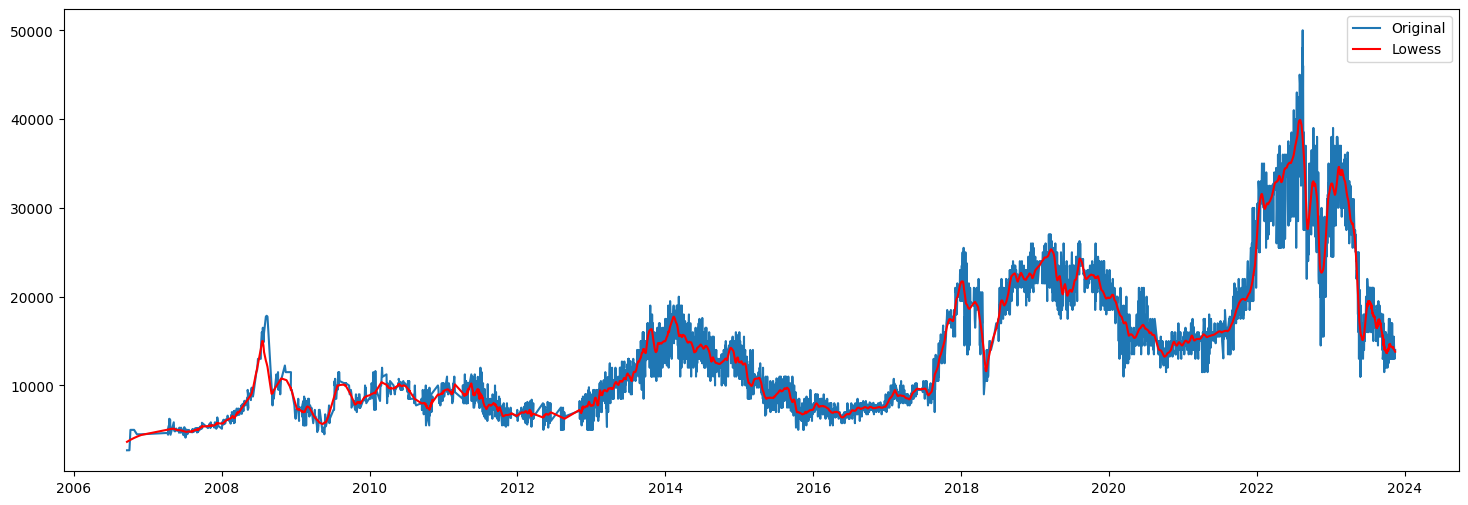

In [4]:
cottonii_df['Date_ordinal'] = cottonii_df['Date'].apply(lambda x: x.toordinal())

# Prepare the data
x = cottonii_df['Date_ordinal']
y = cottonii_df['Average Price']

# Apply Lowess smoothing
frac = 0.005  # Fraction of data used around each point - smaller means more smoothing
lowess = sm.nonparametric.lowess(y, x, frac=frac)

# Extracting the smoothed estimates from the lowess object
lowess_x = list(zip(*lowess))[0]
lowess_y = list(zip(*lowess))[1]

# Adding the smoothed series to the DataFrame
cottonii_df['Lowess'] = np.interp(x, lowess_x, lowess_y)

date_range = pd.date_range(start=cottonii_df['Date'].min(), end=cottonii_df['Date'].max(), freq='D')
date_ordinal_full = date_range.map(pd.Timestamp.toordinal)

cottonii_df = cottonii_df.drop(columns=['Rolling_Median', 'Deviation', 'MAD', 'Outlier', 'Region', 'Species', 'Farmgate Price', 'Collector Price', 'Trader Price'])

# Plotting the results
plt.figure(figsize=(18, 6))
plt.plot(cottonii_df['Date'], cottonii_df['Average Price'], label='Original')
plt.plot(cottonii_df['Date'], cottonii_df['Lowess'], label='Lowess', color='red')
plt.legend()
plt.show()


In [5]:

# Interpolating the smoothed values for the full date range
lowess_y_full = np.interp(date_ordinal_full, lowess_x, lowess_y)

# Adding the smoothed series to a new DataFrame
interpolated_df = pd.DataFrame({
    'Date': date_range,
    'Lowess_Interpolated': lowess_y_full
})

date_to_province = dict(zip(cottonii_df['Date'], cottonii_df['Province']))

# Initialize a list to hold the province values for the interpolated dates
province_interpolated = []

# Assign 'Province' to each date in the interpolated_df by finding the closest previous date in cottonii_df
for interpolated_date in interpolated_df['Date']:
    # If the date exists in the original dataframe, use the corresponding 'Province'
    if interpolated_date in date_to_province:
        province_interpolated.append(date_to_province[interpolated_date])
    else:
        # If the date does not exist, find the closest previous date
        previous_dates = [date for date in date_to_province.keys() if date < interpolated_date]
        closest_previous_date = max(previous_dates) if previous_dates else None
        province_interpolated.append(date_to_province[closest_previous_date] if closest_previous_date else None)

# Add the province information to the interpolated_df
interpolated_df['Province'] = province_interpolated
interpolated_df['Date'] = pd.to_datetime(interpolated_df['Date'])
interpolated_df['Date_ordinal'] = interpolated_df['Date'].apply(lambda x: x.toordinal())

interpolated_df

,Date,Lowess_Interpolated,Province,Date_ordinal
0,2006-09-20,3651.923982,Bali,732574
1,2006-09-21,3665.702330,Bali,732575
2,2006-09-22,3679.480678,Bali,732576
3,2006-09-23,3693.259026,Bali,732577
4,2006-09-24,3707.037374,Bali,732578
...,...,...,...,...
6261,2023-11-11,13971.089294,Sulawesi Selatan,738835
6262,2023-11-12,13930.798327,Sulawesi Selatan,738836
6263,2023-11-13,13888.019873,Sulawesi Selatan,738837
6264,2023-11-14,13843.732498,Sulawesi Selatan,738838


In [10]:
# Set 'Date' as the index
#interpolated_df.set_index('Date', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(interpolated_df['Lowess_Interpolated'], model='additive', period=365)

# Extract the components
interpolated_df['trend'] = result.trend
interpolated_df['seasonal'] = result.seasonal
interpolated_df['residual'] = result.resid

interpolated_df['trend'].fillna(method='ffill', inplace=True)
interpolated_df['residual'].fillna(method='ffill', inplace=True)
interpolated_df

/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_80403/310780881.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  interpolated_df['trend'].fillna(method='ffill', inplace=True)
/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_80403/310780881.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated_df['trend'].fillna(method='ffill', inplace=True)
/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_8040

,Date,Lowess_Interpolated,Province,Date_ordinal,trend,seasonal,residual
0,2006-09-20,3651.923982,Bali,732574,NaN,-476.000936,NaN
1,2006-09-21,3665.702330,Bali,732575,NaN,-463.175885,NaN
2,2006-09-22,3679.480678,Bali,732576,NaN,-452.617493,NaN
3,2006-09-23,3693.259026,Bali,732577,NaN,-436.988166,NaN
4,2006-09-24,3707.037374,Bali,732578,NaN,-422.429084,NaN
...,...,...,...,...,...,...,...
6261,2023-11-11,13971.089294,Sulawesi Selatan,738835,23037.084256,-727.259270,-2635.900086
6262,2023-11-12,13930.798327,Sulawesi Selatan,738836,23037.084256,-727.412992,-2635.900086
6263,2023-11-13,13888.019873,Sulawesi Selatan,738837,23037.084256,-724.604658,-2635.900086
6264,2023-11-14,13843.732498,Sulawesi Selatan,738838,23037.084256,-716.612720,-2635.900086


In [12]:
weather = pd.read_excel('/Users/elissamskog/VSC/alginnova/Prices/Data/weather_data.xlsx')
weather.rename(columns={'Region': 'Province'}, inplace=True)

weather['Date'] = pd.to_datetime(weather['Date'])

weather

,Province,Date,Temperature_Max,Temperature_Min,Precipitation_Sum,Wind_Speed_Max,Sunshine_Duration,Radiation (MJ/m2)
0,NTT,2006-09-20,32.619999,19.470001,0.0,9.983106,41082.359375,26.219999
1,NTT,2006-09-21,32.919998,18.320002,0.0,9.028754,41111.210938,26.690001
2,NTT,2006-09-22,32.619999,19.620001,0.0,8.699793,41139.925781,26.559999
3,NTT,2006-09-23,32.469997,19.420000,0.0,9.360001,41168.464844,25.780001
4,NTT,2006-09-24,32.669998,19.370001,0.0,9.021574,41196.785156,26.920000
...,...,...,...,...,...,...,...,...
138793,Central Java,2023-12-24,33.197002,25.747000,4.7,18.118410,40255.949219,24.150000
138794,Central Java,2023-12-25,32.247002,24.896999,10.1,15.745627,38098.605469,21.330000
138795,Central Java,2023-12-26,32.647003,24.497000,10.9,14.799459,41410.589844,22.990000
138796,Central Java,2023-12-27,32.697002,25.347000,3.5,15.111424,41876.968750,22.230000


Create the weather feature "weather_quality" by assuming a normal distribution over each weather variable.

In [13]:
optimal_conditions = [
    [30, 5], # Max Temperature
    [20, 5], # Min Temperature
    [10, 3], # Wind Speed
    [25, 3]  # Radiation (MJ/m2)
]

def calculate_weather_quality(date, region, weather_df):
    # Find the start date, 45 days before 'date'
    start_date = date - pd.Timedelta(days=45)
    # Filter the weather DataFrame for the region and the 45-day period
    relevant_weather = weather_df[(weather_df['Date'] >= start_date) & (weather_df['Date'] < date) & (weather_df['Province'] == region)]
    
    # Initialize the Weather Quality Index
    wqi = 0
    
    # Calculate z-scores for each weather variable
    for (opt_value, stdev), column in zip(optimal_conditions, ['Temperature_Max', 'Temperature_Min', 'Wind_Speed_Max', 'Radiation (MJ/m2)']):
        if relevant_weather[column].empty:
            continue  # Skip if there is no data
        
        mean_value = relevant_weather[column].mean()
        stdev_w = relevant_weather[column].std()
        # Calculate the z-score
        z_score = (mean_value - opt_value) / stdev
        # We sum the absolute value of the negative z-scores to make a lower WQI preferable
        wqi += abs(z_score)
    return wqi

for index, row in interpolated_df.iterrows():
    # Ensure the date is in datetime format
    date = pd.to_datetime(row['Date'])  # Convert to datetime if it's not already
    # Call the function with the date and region
    weather_quality = calculate_weather_quality(date, row['Province'], weather)
    # Append the weather quality value to the DataFrame
    interpolated_df.loc[index, 'Weather_Quality'] = weather_quality


interpolated_df

,Date,Lowess_Interpolated,Province,Date_ordinal,trend,seasonal,residual,Weather_Quality
0,2006-09-20,3651.923982,Bali,732574,NaN,-476.000936,NaN,0.000000
1,2006-09-21,3665.702330,Bali,732575,NaN,-463.175885,NaN,0.923734
2,2006-09-22,3679.480678,Bali,732576,NaN,-452.617493,NaN,0.497901
3,2006-09-23,3693.259026,Bali,732577,NaN,-436.988166,NaN,0.698156
4,2006-09-24,3707.037374,Bali,732578,NaN,-422.429084,NaN,0.707948
...,...,...,...,...,...,...,...,...
6261,2023-11-11,13971.089294,Sulawesi Selatan,738835,23037.084256,-727.259270,-2635.900086,4.313096
6262,2023-11-12,13930.798327,Sulawesi Selatan,738836,23037.084256,-727.412992,-2635.900086,4.256472
6263,2023-11-13,13888.019873,Sulawesi Selatan,738837,23037.084256,-724.604658,-2635.900086,4.211956
6264,2023-11-14,13843.732498,Sulawesi Selatan,738838,23037.084256,-716.612720,-2635.900086,4.198222


Fit a model using the dependent variable of price, adjusted for by in the lowess curve.

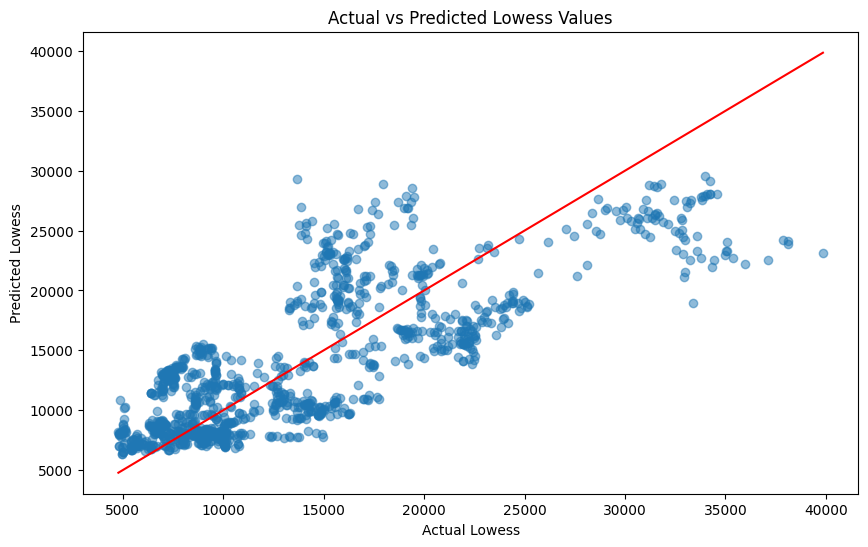

Mean Squared Error: 19668041.11559394
R-squared: 0.6243962276957997


In [14]:
interpolated_df = interpolated_df.dropna()


y = interpolated_df['Lowess_Interpolated']
X = interpolated_df[['Weather_Quality', 'Date_ordinal', 'seasonal']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

degree = 2  # You can adjust the degree of the polynomial here
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('linear_regression', LinearRegression())
])

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing data
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs Predicted Lowess Values')
plt.xlabel('Actual Lowess')
plt.ylabel('Predicted Lowess')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line for perfect prediction
plt.show()
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [15]:
# Convert 'Date' to a numeric format for regression (e.g., ordinal)
interpolated_df['Date_ordinal'] = interpolated_df['Date'].apply(lambda x: x.toordinal())
interpolated_df['Date'] = pd.to_datetime(interpolated_df['Date'])

# Select one year with complete data, for example, 2020
# Adjust the year according to your dataset
year_to_use = 2022
seasonal_year_data = interpolated_df[interpolated_df['Date'].dt.year == year_to_use]['seasonal']

# Generate a DataFrame for one full year (e.g., 2020)
full_year_dates = pd.date_range(start=f'{year_to_use}-01-01', end=f'{year_to_use}-12-31')
full_year_seasonal = pd.DataFrame({'Date': full_year_dates, 'Seasonal_Component': seasonal_year_data.values})

# Adjust 'full_year_seasonal' to only include the 'Seasonal_Component' column, indexed by day of the year
full_year_seasonal['DayOfYear'] = full_year_seasonal['Date'].dt.dayofyear
seasonal_pattern = full_year_seasonal.set_index('DayOfYear')['Seasonal_Component']

# Fit a linear regression model
model = LinearRegression()
X = interpolated_df[['Date_ordinal']]
y = interpolated_df['trend']
model.fit(X, y)

# Predict future trend values
num_days = 100  # Number of days to forecast
last_date = interpolated_df['Date'].iloc[-1]
future_dates = [last_date + pd.DateOffset(days=x) for x in range(1, num_days + 1)]
future_dates_ordinal = [d.toordinal() for d in future_dates]

# Predict
future_trend = model.predict(np.array(future_dates_ordinal).reshape(-1, 1))

# Create a DataFrame for future trend values
future_trend_df = pd.DataFrame({'Date': future_dates, 'Future_Trend': future_trend})

/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_80403/1121785627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['Date_ordinal'] = interpolated_df['Date'].apply(lambda x: x.toordinal())
/var/folders/g5/_h0nvbpj2451rrdhqr_ss2280000gn/T/ipykernel_80403/1121785627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_df['Date'] = pd.to_datetime(interpolated_df['Date'])
/Users/elissamskog/VSC/alginnova/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

In [16]:
forecast_weather = pd.read_excel('/Users/elissamskog/JupyterProjects/Prices/Data/forecast_data.xlsx')
forecast_weather.rename(columns={'Region': 'Province'}, inplace=True)

forecast_weather['Date'] = pd.to_datetime(forecast_weather['Date'])

# Concatenate the DataFrames
combined_df = pd.concat([weather, forecast_weather])

# Sort by 'Region' and 'Date'
combined_df.sort_values(by=['Province', 'Date'], inplace=True)

# Reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)
start_date = datetime(2024, 1, 25)  # starting the day after your current dataset

# Create a DataFrame for future dates
future_dates = [start_date + timedelta(days=x) for x in range(num_days)]
future_df = pd.DataFrame(future_dates, columns=['Date'])

future_df['Date_ordinal'] = future_df['Date'].apply(lambda x: x.toordinal())

future_df['Weather_Quality'] = pd.NA

# Update the code to calculate weather_quality
for index, row in future_df.iterrows():
    date = pd.to_datetime(row['Date'])
    # Assuming you have a function calculate_weather_quality and a variable 'province'
    weather_quality = calculate_weather_quality(date, 'Bali', combined_df)  # replace 'province' as needed
    future_df.at[index, 'Weather_Quality'] = weather_quality

future_df['Date'] = pd.to_datetime(future_df['Date'])

# Merge trend data
future_df = future_df.merge(future_trend_df, on='Date', how='left')

# Add seasonal component based on the day of the year
future_df['DayOfYear'] = future_df['Date'].dt.dayofyear
future_df['Seasonal'] = future_df['DayOfYear'].map(seasonal_pattern)

# Drop 'DayOfYear' if no longer needed
future_df.drop('DayOfYear', axis=1, inplace=True)

future_df = future_df.dropna()
future_df

FileNotFoundError: [Errno 2] No such file or directory: '/Users/elissamskog/JupyterProjects/Prices/Data/forecast_data.xlsx'

In [ ]:
X = future_df[['Weather_Quality', 'Date_ordinal', 'Future_Trend']]
y_pred = pipeline.predict(X)
final_predictions = y_pred + future_df['Seasonal']

final_forecast_df = pd.DataFrame({
    'Date': future_df['Date'],
    'Final_Forecast': final_predictions
})

final_forecast_df

/Users/elissamskog/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Future_Trend
Feature names seen at fit time, yet now missing:
- trend

  warnings.warn(message, FutureWarning)


,Date,Final_Forecast
0,2024-01-25,22228.148061
1,2024-01-26,22230.416406
2,2024-01-27,22233.578175
3,2024-01-28,22237.428901
4,2024-01-29,22238.628058
5,2024-01-30,22242.870548
6,2024-01-31,22252.340549
7,2024-02-01,22268.799854
8,2024-02-02,22285.315823
9,2024-02-03,22301.312722
